# 导入包

In [1]:
import pdb, os, shutil, datetime, math, sys

In [2]:
from zlib import crc32

In [3]:
import matplotlib.pyplot as plt

In [4]:
import numpy as np
import pandas as pd

In [5]:
import tensorflow as tf

In [19]:
# 任务路径
strJobsDir = "../jobs_test"

# 工具函数

通过任务文件夹路径获取解调器文件夹路径函数

In [7]:
def fn_getDemodDirsOfAJob(strJobDir):
    liststrDemodDirs = [os.path.join(strJobDir, strName) for strName in os.listdir(strJobDir) if "Demod" in strName]
    return liststrDemodDirs

In [8]:
def fn_printBar(nEpoch):
    sys.stdout.write(f"\r{nEpoch:d}/{g_nEpochs}")
    sys.stdout.flush()

计算分数的函数
通过输入样本集和Ge，Gd，Ge1输出样本集中每个样本的分数的函数。

In [11]:
def fn_score(pdDfSamples, oSeqGe, oSeqGd, oSeqGe1):
    if pdDfSamples.empty:
        pdDfScores = pd.DataFrame(columns=["scores"])
        return pdDfScores
    
    listScores = []
    tensorSamples = tf.constant(pdDfSamples.values)
    # Apperant loss
    for tensorSample in tensorSamples:
        tensorSample = tensorSample[tf.newaxis, ...]
        tensorEncodedSample = oSeqGe(tensorSample)
        tensorFakeSample = oSeqGd(tensorEncodedSample)
        tensorApperantLoss = tf.reduce_mean(tf.losses.mean_absolute_error(tensorSample, tensorFakeSample))

        # Latent loss
        tensorEncoded1Sample = oSeqGe1(tensorFakeSample)
        tensorLatentLoss = \
            tf.reduce_mean(tf.losses.mean_squared_error(tensorEncodedSample, tensorEncoded1Sample))
        
        tensorScore = tensorApperantLoss + tensorLatentLoss
        listScores.append(tensorScore.numpy())
    pdDfScores = pd.DataFrame(data=listScores, columns=["scores"], index=pdDfSamples.index)
    return pdDfScores

# 帧同步锁前

因为在MNIST中的样本有784个属性。用于分类的模型也只有2层。所以在整个解扰前的训练中，我使用的模型的层数均不变。

只随着样本属性的增加，增加每层的神经元个数。

## 训练函数
训练模型，模型用全局变量表示。

如果在某个迭代的最终损失不小于前一次迭代，终止循环，返回前一次迭代的生成器的三个元素。

In [106]:
def fn_train(oGAN): 
    def fn_getGLoss(tensorInput):
        # Apperant loss
        tensorEncodedSamples = oGAN.oSeqGe(tensorInput)
        tensorFakeSamples = oGAN.oSeqGd(tensorEncodedSamples)
        tensorApperantLoss = tf.reduce_mean(tf.losses.mean_absolute_error(tensorInput, tensorFakeSamples))

        # Latent loss
        tensorEncoded1Samples = oGAN.oSeqGe1(tensorFakeSamples)
        tensorLatentLoss = \
        tf.reduce_mean(tf.losses.mean_squared_error(tensorEncodedSamples, tensorEncoded1Samples))

        # Feature matching loss
        tensorPredFeatures = oGAN.oSeqDInner(tensorFakeSamples)
        tensorTrueFeatures = oGAN.oSeqDInner(tensorInput)
        tensorFeatureLoss = tf.reduce_mean(tf.losses.mean_squared_error(tensorPredFeatures, tensorTrueFeatures))

        tensorGLoss = tensorApperantLoss + tensorLatentLoss + tensorFeatureLoss
        return tensorGLoss
    # 在每个epoch后存储最小的ALoss和对应的
    fGLossLast = np.inf
    # 存储生成器的解码器和译码器
    oSeqLastGe = None
    oSeqLastGd = None
    oSeqLastGe1 = None
    # 开始训练，输出训练的开始时间和训练的结束时间
    nStep = 0
    print(datetime.datetime.now())
    for nEpoch in range(g_nEpochs):
        for tensorBatch in oDataset:
            # Train discriminator
            # Generator fake samples
            tensorEncodedSamples = oGAN.oSeqGe(tensorBatch)
            tensorFakeSamples = oGAN.oSeqGd(tensorEncodedSamples)
            with tf.GradientTape() as oGradientTapeD:
                # Train discriminator with real samples
                tensorLabels = tf.random.uniform(minval=0.7, maxval=1.2, seed=42, shape=(tensorBatch.shape[0], 1))
                tensorPreds = oGAN.oSeqD(tensorBatch)
                tensorDLossR = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(tensorLabels, tensorPreds))
            listDGradients = oGradientTapeD.gradient(tensorDLossR, oGAN.oSeqD.trainable_variables)
            oOptimizerD.apply_gradients(zip(listDGradients, oGAN.oSeqD.trainable_variables))
            with tf.GradientTape() as oGradientTapeD:
                # Train discriminator with fake samples
                tensorLabels = tf.random.uniform(minval=0., maxval=0.3, seed = 42, shape=(tensorFakeSamples.shape[0], 1))
                tensorPreds = oGAN.oSeqD(tensorFakeSamples)
                tensorDLossF = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(tensorLabels, tensorPreds))
            listDGradients = oGradientTapeD.gradient(tensorDLossF, oGAN.oSeqD.trainable_variables)
            oOptimizerD.apply_gradients(zip(listDGradients, oGAN.oSeqD.trainable_variables))
            tensorDLoss = tensorDLossR + tensorDLossF
            with oSummaryWriterDLoss.as_default():
                tf.summary.scalar("D_Loss", tensorDLoss, nStep)

            # Train genertor
            with tf.GradientTape() as oGradientTapeG:
                tensorGLoss = fn_getGLoss(tensorBatch)
            # Insert all generator trainable variables into a list
            listTrainableGVariables = []
            listTrainableGVariables.extend(oGAN.oSeqGe.trainable_variables)
            listTrainableGVariables.extend(oGAN.oSeqGd.trainable_variables)
            listTrainableGVariables.extend(oGAN.oSeqGe1.trainable_variables)

            listGGradients = oGradientTapeG.gradient(tensorGLoss, listTrainableGVariables)
            oOptimizerG.apply_gradients(zip(listGGradients, listTrainableGVariables))
            with oSummaryWriterALoss.as_default():
                tf.summary.scalar("A_loss", tensorGLoss, nStep)

            nStep = nStep + 1
            
        # 在整个训练集上计算generator的损失，并比较和上一次迭代的损失，如果小于上一次迭代，更新损失和最有模型；反之停止训练
        tensorGLossOverTotalSamples = fn_getGLoss(g_tensorNormalTrainingSamples)
        if fGLossLast > tensorGLossOverTotalSamples.numpy():
            fGLossLast = tensorGLossOverTotalSamples.numpy()
            oSeqLastGe = oGAN.oSeqGe
            oSeqLastGd = oGAN.oSeqGd
            oSeqLastGe1 = oGAN.oSeqGe1
        # 输出进度
        fn_printBar(nEpoch)
    return oSeqLastGe, oSeqLastGd, oSeqLastGe1
    print(datetime.datetime.now())

    

## 中频控制

利用中频控制的训练样本训练模型，再用模型为测试样本打分。分数越高样本越异常。为测试集打分时，测试集中的正常样本应该分数很低，异常样本中的有一部分应该分数低，一部分分数高。

### 构造建立模型

为了能够将训练好的模型保存起来，每个独立的模型的第一层都是tf.keras.Input(shape=(inputshape, ))

In [296]:
class GANifu(object):
    def __init__(self):
        self.fn_makeGenerator()
        self.fn_makeDiscriminator()
        
    def fn_makeGenerator(self):
        self.oSeqGe = tf.keras.Sequential(name="Ge")
        self.oSeqGe.add(tf.keras.Input(shape=(5,)))
        self.oSeqGe.add(tf.keras.layers.Dense(3, kernel_initializer="he_normal"))
        self.oSeqGe.add(tf.keras.layers.LeakyReLU())
        self.oSeqGe.add(tf.keras.layers.BatchNormalization())
        self.oSeqGe.add(tf.keras.layers.Dense(3, kernel_initializer="he_normal"))
        self.oSeqGe.add(tf.keras.layers.LeakyReLU())

        self.oSeqGd = tf.keras.Sequential(name="Gd")
        self.oSeqGd.add(tf.keras.Input(shape=(3,)))
        self.oSeqGd.add(tf.keras.layers.Dense(3, kernel_initializer="he_normal"))
        self.oSeqGd.add(tf.keras.layers.LeakyReLU())
        self.oSeqGd.add(tf.keras.layers.BatchNormalization())
        self.oSeqGd.add(tf.keras.layers.Dense(5, activation = tf.keras.activations.sigmoid))
        
        self.oSeqGe1 = tf.keras.Sequential(name="Ge1")
        self.oSeqGe1.add(tf.keras.Input(shape=(5,)))
        self.oSeqGe1.add(tf.keras.layers.Dense(3, kernel_initializer="he_normal"))
        self.oSeqGe1.add(tf.keras.layers.LeakyReLU())
        self.oSeqGe1.add(tf.keras.layers.BatchNormalization())
        self.oSeqGe1.add(tf.keras.layers.Dense(3, kernel_initializer="he_normal"))
        self.oSeqGe1.add(tf.keras.layers.LeakyReLU())
        
    def fn_makeDiscriminator(self):
        self.oSeqDInner = tf.keras.Sequential(name="DInner")
        self.oSeqDInner.add(tf.keras.Input(shape=(5,)))
        self.oSeqDInner.add(tf.keras.layers.Dense(3, kernel_initializer="he_normal"))
        self.oSeqDInner.add(tf.keras.layers.LeakyReLU())
        self.oSeqDInner.add(tf.keras.layers.BatchNormalization())
        self.oSeqDInner.add(tf.keras.layers.Dense(3, kernel_initializer="he_normal"))
        self.oSeqDInner.add(tf.keras.layers.LeakyReLU())
        self.oSeqDInner.add(tf.keras.layers.BatchNormalization())

        self.oSeqD = tf.keras.Sequential([
            self.oSeqDInner,
            tf.keras.layers.Dense(1, activation = tf.keras.activations.sigmoid)
        ], name="D")

In [311]:
# 新建模型
tf.keras.backend.clear_session()
oGANifu = GANifu()

### 构造数据集

In [312]:
g_nFeatures = 5
g_nBatchSize = 256

def fn_splitCsvLine(strLine):
    tensorDefs = [0.] * g_nFeatures
    tensorRecord = tf.io.decode_csv(strLine, record_defaults=tensorDefs)
    tensorX = tf.stack(tensorRecord)
    return tensorX

oDataset = tf.data.Dataset.list_files(strJobsDir + "/*/*/parts/sync/ifu/samples/normal/train/preprocessed/samples.csv")
oDataset = oDataset.interleave(lambda strSamplesFile: tf.data.TextLineDataset(strSamplesFile).skip(1), \
                              cycle_length=5, num_parallel_calls=5)
oDataset = oDataset.map(fn_splitCsvLine, 5)
oDataset = oDataset.shuffle(1000)
oDataset= oDataset.batch(g_nBatchSize)

In [299]:
# 读入所有的训练样本，从而通过shape属性得到训练集大小，存入全局变量中
listPreprocessedNormalTrainingSamples = []
for strJob in os.listdir(strJobsDir):
    strJobDir = os.path.join(strJobsDir, strJob)
    listDemodDirs = fn_getDemodDirsOfAJob(strJobDir)
    for strDemodDir in listDemodDirs:
        strPreprocessedNormalTrainingSamplesFile = os.path.join(strDemodDir, \
                                                   "parts/sync/ifu/samples/normal/train/preprocessed/samples.csv")
        pdDfPreprocessedNormalTrainingSamples = pd.read_csv(strPreprocessedNormalTrainingSamplesFile)
        listPreprocessedNormalTrainingSamples.append(pdDfPreprocessedNormalTrainingSamples)
pdDfPreprocessedNormalTrainingSamples = pd.concat(listPreprocessedNormalTrainingSamples)
g_tensorNormalTrainingSamples = tf.constant(pdDfPreprocessedNormalTrainingSamples.values, dtype=tf.float32)
g_nTrainingSize = len(g_tensorNormalTrainingSamples)

### 训练

In [313]:
# 构造优化器。
# 利用ExponentialDecay的方法构造优化器。
g_nEpochs = 300
nSteps = g_nEpochs * g_nTrainingSize // g_nBatchSize
oExponentialDecay = tf.keras.optimizers.schedules.ExponentialDecay(1e-2, nSteps, 1e-1)
oOptimizerG = tf.keras.optimizers.Adam(learning_rate=oExponentialDecay)
oOptimizerD = tf.keras.optimizers.SGD(learning_rate=oExponentialDecay)

In [314]:
# 构造日志
strPrefix = datetime.datetime.now().strftime("%H_%M_%S")
strPrefix = "{}".format(strPrefix)
oSummaryWriterDLoss = tf.summary.create_file_writer("logs/ifu/" + strPrefix + "_D")
oSummaryWriterALoss = tf.summary.create_file_writer("logs/ifu/" + strPrefix + "_A")

In [315]:
oSeqGe, oSeqGd, oSeqGe1 = fn_train(oGANifu)

2020-02-21 19:56:54.293364
299/300

In [316]:
# 保存模型
oSeqGe.save("models/sync/ifu/Ge.h5")
oSeqGd.save("models/sync/ifu/Gd.h5")
oSeqGe1.save("models/sync/ifu/Ge1.h5")

### 评估
然后利用训练好的模型算出测试集样本的分数，存档。

从文件夹中载入训练好的模型。

遍历每个解调器的测试集，将相应的分数存入preprocessed/scores.csv中

In [9]:
oSeqGe = tf.keras.models.load_model("models/have_test/sync/ifu/Ge.h5")
oSeqD = tf.keras.models.load_model("models/have_test/sync/ifu/Gd.h5")
oSeqGe1 = tf.keras.models.load_model("models/have_test/sync/ifu/Ge1.h5")

计算测试样本分数并存档
执行后：
* samples/
    * normal/
        * test/
            * preprocessed/
                * samples.csv
                * scores.csv
    * abnormal/
        * preprocessed/
            * samples.csv
            * scores.csv
      
在分数后面要添上由解调器名和rectime组成的id，方便画图的时候把同一解调器在同一任务的样本分开。画图的时候要把id和总的横坐标值取模，模的结果作为最终的横坐标。

In [12]:
# Test samples
for strJob in os.listdir("../jobs"):
    listDemodDirs = fn_getDemodDirsOfAJob(os.path.join(strJobsDir, strJob))
    for strDemodDir in listDemodDirs:
        strPreprocessedSamplesDir = os.path.join(strDemodDir, "parts/sync/ifu/samples/normal/test/preprocessed")
        strPreprocessedSamplesFile = os.path.join(strPreprocessedSamplesDir, "samples.csv")
        pdDfPreprocessedSamples = pd.read_csv(strPreprocessedSamplesFile, index_col="RECTIME")
        # 分数csv包含scores列
        pdDfScores = fn_score(pdDfPreprocessedSamples, oSeqGe, oSeqD, \
                              oSeqGe1)
        # 下面再csv里面添加id_num
        strDemod = os.path.split(strDemodDir)[1]
        pdSeriesId = pd.Series(data=pdDfScores.index, name="id")
        pdSeriesId = pdSeriesId.apply(lambda id: crc32(str.encode(strDemod + id)))
        pdDfScores["id"] = pdSeriesId.values
        strScoresFile = os.path.join(strPreprocessedSamplesDir, "scores.csv")
        pdDfScores.to_csv(strScoresFile, index_label="RECTIME")
        
# Abnormal samples
for strJob in os.listdir("../jobs"):
    listDemodDirs = fn_getDemodDirsOfAJob(os.path.join(strJobsDir, strJob))
    for strDemodDir in listDemodDirs:
        strPreprocessedSamplesDir = os.path.join(strDemodDir, "parts/sync/ifu/samples/abnormal/preprocessed")
        strPreprocessedSamplesFile = os.path.join(strPreprocessedSamplesDir, "samples.csv")
        pdDfPreprocessedSamples = pd.read_csv(strPreprocessedSamplesFile, index_col="RECTIME")
        pdDfScores = fn_score(pdDfPreprocessedSamples, oSeqGe, oSeqD, \
                              oSeqGe1)
        # 下面再csv里面添加id_num
        # 用解调器名和分数对应的RECTIME组合成一个大的字符串，然后对这个大的字符串进行crc32编码，编出一个独一无二的大整数
        strDemod = os.path.split(strDemodDir)[1]
        pdSeriesId = pd.Series(data=pdDfScores.index, name="id")
        pdSeriesId = pdSeriesId.apply(lambda id: crc32(str.encode(strDemod + id)))
        pdDfScores["id"] = pdSeriesId.values
        strScoresFile = os.path.join(strPreprocessedSamplesDir, "scores.csv")
        pdDfScores.to_csv(strScoresFile, index_label="RECTIME")

In [13]:
# 读入正常测试样本和异常测试样本的分数，分别存入numpy数组
listScores = []
listX = []
for strJob in os.listdir(strJobsDir):
    strJobDir = os.path.join(strJobsDir, strJob)
    listDemodDirs = fn_getDemodDirsOfAJob(strJobDir)
    for strDemodDir in listDemodDirs:
        strNormalTestingScoresFile = os.path.join(strDemodDir, \
                                                  "parts/sync/ifu/samples/normal/test/preprocessed/scores.csv")
        pdDfNormalTestingScores = pd.read_csv(strNormalTestingScoresFile, index_col="RECTIME")
        if not pdDfNormalTestingScores.empty:
            listScores.append(pdDfNormalTestingScores["scores"].values)
            # 分数的横坐标
            listX.append(pdDfNormalTestingScores["id"].values)
npNormalScores = np.concatenate(listScores)
npNormalX = np.concatenate(listX)

listScores = []
listX = []
for strJob in os.listdir(strJobsDir):
    strJobDir = os.path.join(strJobsDir, strJob)
    listDemodDirs = fn_getDemodDirsOfAJob(strJobDir)
    for strDemodDir in listDemodDirs:
        strAbnormalTestingScoresFile = os.path.join(strDemodDir, \
                                                  "parts/sync/ifu/samples/abnormal/preprocessed/scores.csv")
        pdDfAbnormalTestingScores = pd.read_csv(strAbnormalTestingScoresFile, index_col="RECTIME")
        if not pdDfAbnormalTestingScores.empty:
            listScores.append(pdDfAbnormalTestingScores["scores"].values)
            # 分数的横坐标
            listX.append(pdDfAbnormalTestingScores["id"].values)
npAbnormalScores = np.concatenate(listScores)
npAbnormalX = np.concatenate(listX)

In [15]:
nTotalLen = npNormalX.shape[0] + npAbnormalX.shape[0]

In [16]:
# 将正常测试样本的最大分数作为阈值，如果异常测试样本的分数大于该值则判错，小于判对
fThreshold = np.sort(npNormalScores)[-1]#[int(len(npNormalScores) * 0.995)]

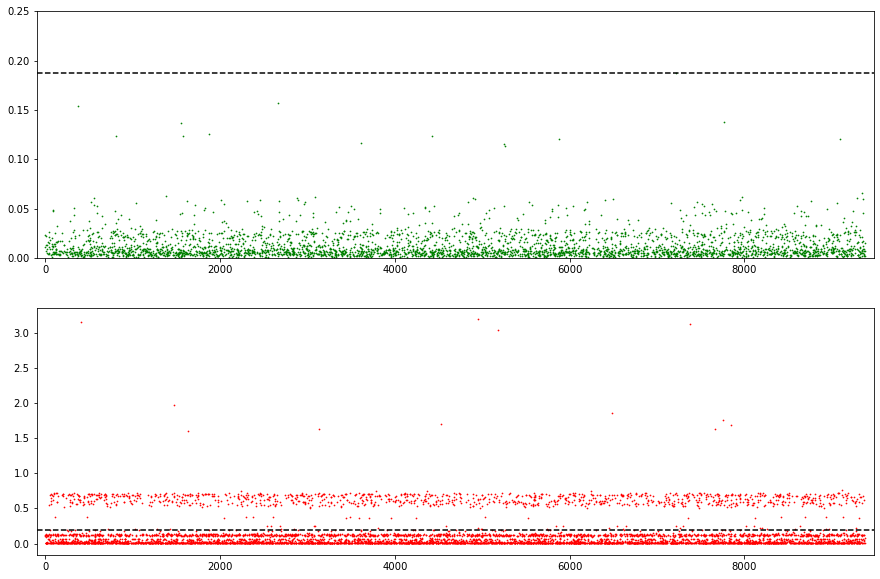

In [18]:
# 做出散点图。其中，虚线表示阈值。
plt.figure(figsize=(15, 10))
plt.subplot(2, 1, 1)
plt.scatter(npNormalX % nTotalLen, npNormalScores, c="green", s=0.5)
plt.hlines(fThreshold, xmin=-100, xmax=nTotalLen + 100, linestyles="dashed")
plt.xlim([-100, nTotalLen + 100])
plt.ylim([0, 0.25])

plt.subplot(2, 1, 2)
plt.scatter(npAbnormalX % nTotalLen, npAbnormalScores, c="red", s=0.5)
plt.hlines(fThreshold, xmin=-100, xmax=nTotalLen + 100, linestyles="dashed")
plt.xlim([-100, nTotalLen + 100])
#plt.ylim([0, 0.25])
plt.show()

把高于阈值的异常样本存入以部分的名字命名的dataframe文件中。multiindex=任务名+解调器名  域=上报时间点

In [21]:
listAbnormalifu = []
for strJob in os.listdir(strJobsDir):
    listDemodDirs = fn_getDemodDirsOfAJob(os.path.join(strJobsDir, strJob))
    for strDemodDir in listDemodDirs:
        pdDfScores = pd.read_csv(os.path.join(strDemodDir, "parts/sync/ifu/samples/abnormal/preprocessed/scores.csv"), \
                                 index_col="RECTIME")
        pdDfSamples = pd.read_csv(os.path.join(strDemodDir, "parts/sync/ifu/samples/abnormal/samples.csv"), \
                                    index_col="RECTIME")
        for index in pdDfScores.index:
            if pdDfScores.loc[index, "scores"] > fThreshold:
                listAbnormalifu.append(pdDfSamples.loc[index, :])
pdDfAbnormalifuRecords = pd.DataFrame(listAbnormalifu)
pdDfAbnormalifuRecords.to_csv("../ifu.csv", index_label="RECTIME")

## 输入

### 构造建立模型

由于有7个属性，所以

In [327]:
class GANinput(object):
    def __init__(self):
        self.fn_makeGenerator()
        self.fn_makeDiscriminator()
        
    def fn_makeGenerator(self):
        self.oSeqGe = tf.keras.Sequential(name="Ge")
        self.oSeqGe.add(tf.keras.Input(shape=(7,)))
        self.oSeqGe.add(tf.keras.layers.Dense(5, kernel_initializer="he_normal"))
        self.oSeqGe.add(tf.keras.layers.LeakyReLU())
        self.oSeqGe.add(tf.keras.layers.BatchNormalization())
        self.oSeqGe.add(tf.keras.layers.Dense(5, kernel_initializer="he_normal"))
        self.oSeqGe.add(tf.keras.layers.LeakyReLU())

        self.oSeqGd = tf.keras.Sequential(name="Gd")
        self.oSeqGd.add(tf.keras.Input(shape=(5,)))
        self.oSeqGd.add(tf.keras.layers.Dense(5, kernel_initializer="he_normal"))
        self.oSeqGd.add(tf.keras.layers.LeakyReLU())
        self.oSeqGd.add(tf.keras.layers.BatchNormalization())
        self.oSeqGd.add(tf.keras.layers.Dense(7, activation = tf.keras.activations.sigmoid))
        
        self.oSeqGe1 = tf.keras.Sequential(name="Ge1")
        self.oSeqGe1.add(tf.keras.Input(shape=(7,)))
        self.oSeqGe1.add(tf.keras.layers.Dense(5, kernel_initializer="he_normal"))
        self.oSeqGe1.add(tf.keras.layers.LeakyReLU())
        self.oSeqGe1.add(tf.keras.layers.BatchNormalization())
        self.oSeqGe1.add(tf.keras.layers.Dense(5, kernel_initializer="he_normal"))
        self.oSeqGe1.add(tf.keras.layers.LeakyReLU())
        
    def fn_makeDiscriminator(self):
        self.oSeqDInner = tf.keras.Sequential(name="DInner")
        self.oSeqDInner.add(tf.keras.Input(shape=(7,)))
        self.oSeqDInner.add(tf.keras.layers.Dense(5, kernel_initializer="he_normal"))
        self.oSeqDInner.add(tf.keras.layers.LeakyReLU())
        self.oSeqDInner.add(tf.keras.layers.BatchNormalization())
        self.oSeqDInner.add(tf.keras.layers.Dense(5, kernel_initializer="he_normal"))
        self.oSeqDInner.add(tf.keras.layers.LeakyReLU())
        self.oSeqDInner.add(tf.keras.layers.BatchNormalization())

        self.oSeqD = tf.keras.Sequential([
            self.oSeqDInner,
            tf.keras.layers.Dense(1, activation = tf.keras.activations.sigmoid)
        ], name="D")

In [336]:
# 新建模型
tf.keras.backend.clear_session()
oGANinput = GANinput()

### 构造数据集

In [331]:
g_nFeatures = 7
g_nBatchSize = 256

def fn_splitCsvLine(strLine):
    tensorDefs = [0.] * g_nFeatures
    tensorRecord = tf.io.decode_csv(strLine, record_defaults=tensorDefs)
    tensorX = tf.stack(tensorRecord)
    return tensorX

oDataset = tf.data.Dataset.list_files(strJobsDir + "/*/*/parts/sync/input/samples/normal/train/preprocessed/samples.csv")
oDataset = oDataset.interleave(lambda strSamplesFile: tf.data.TextLineDataset(strSamplesFile).skip(1), \
                              cycle_length=5, num_parallel_calls=5)
oDataset = oDataset.map(fn_splitCsvLine, g_nFeatures)
oDataset = oDataset.shuffle(1000)
oDataset = oDataset.batch(g_nBatchSize)

In [335]:
# 读入所有的训练样本，从而通过shape属性得到训练集大小，存入全局变量中
listPreprocessedNormalTrainingSamples = []
for strJob in os.listdir(strJobsDir):
    strJobDir = os.path.join(strJobsDir, strJob)
    listDemodDirs = fn_getDemodDirsOfAJob(strJobDir)
    for strDemodDir in listDemodDirs:
        strPreprocessedNormalTrainingSamplesFile = os.path.join(strDemodDir, \
                                                   "parts/sync/input/samples/normal/train/preprocessed/samples.csv")
        pdDfPreprocessedNormalTrainingSamples = pd.read_csv(strPreprocessedNormalTrainingSamplesFile)
        listPreprocessedNormalTrainingSamples.append(pdDfPreprocessedNormalTrainingSamples)
pdDfPreprocessedNormalTrainingSamples = pd.concat(listPreprocessedNormalTrainingSamples)
g_tensorNormalTrainingSamples = tf.constant(pdDfPreprocessedNormalTrainingSamples.values, dtype=tf.float32)
g_nTrainingSize = len(g_tensorNormalTrainingSamples)

### 训练

In [337]:
# g_nTrainingSize在中频控制已经设置好了
g_nEpochs = 300
nSteps = g_nEpochs * g_nTrainingSize // g_nBatchSize
oExponentialDecay = tf.keras.optimizers.schedules.ExponentialDecay(1e-2, nSteps, 1e-1)
oOptimizerG = tf.keras.optimizers.Adam(learning_rate=oExponentialDecay)
oOptimizerD = tf.keras.optimizers.SGD(learning_rate=oExponentialDecay)

In [338]:
# 构造日志
strPrefix = datetime.datetime.now().strftime("%H_%M_%S")
strPrefix = "{}".format(strPrefix)
oSummaryWriterDLoss = tf.summary.create_file_writer("logs/input/" + strPrefix + "_D")
oSummaryWriterALoss = tf.summary.create_file_writer("logs/input/" + strPrefix + "_A")

In [339]:
oSeqGe, oSeqGd, oSeqGe1 = fn_train(oGANinput)

2020-02-21 20:43:15.969963
299/300

保存模型

In [340]:
oSeqGe.save("models/sync/input/Ge.h5")
oSeqGd.save("models/sync/input/Gd.h5")
oSeqGe1.save("models/sync/input/Ge1.h5")

### 评估
然后利用训练好的模型算出测试集样本的分数，存档。

从文件夹中载入训练好的模型。

遍历每个解调器的测试集，将相应的分数存入preprocessed/scores.csv中

In [79]:
oSeqGe = tf.keras.models.load_model("models/sync/input/Ge.h5")
oSeqD = tf.keras.models.load_model("models/sync/input/Gd.h5")
oSeqGe1 = tf.keras.models.load_model("models/sync/input/Ge1.h5")

计算测试样本分数并存档
执行后：
* samples/
    * normal/
        * test/
            * preprocessed/
                * samples.csv
                * scores.csv
    * abnormal/
        * preprocessed/
            * samples.csv
            * scores.csv

In [80]:
# Test samples
for strJob in os.listdir("../jobs"):
    listDemodDirs = fn_getDemodDirsOfAJob(os.path.join(strJobsDir, strJob))
    for strDemodDir in listDemodDirs:
        strPreprocessedSamplesDir = os.path.join(strDemodDir, "parts/sync/input/samples/normal/test/preprocessed")
        strPreprocessedSamplesFile = os.path.join(strPreprocessedSamplesDir, "samples.csv")
        pdDfPreprocessedSamples = pd.read_csv(strPreprocessedSamplesFile, index_col="RECTIME")
        # 分数csv包含scores列
        pdDfScores = fn_score(pdDfPreprocessedSamples, oSeqGe, oSeqD, \
                              oSeqGe1)
        # 下面再csv里面添加id_num
        strDemod = os.path.split(strDemodDir)[1]
        pdSeriesId = pd.Series(data=pdDfScores.index, name="id")
        pdSeriesId = pdSeriesId.apply(lambda id: crc32(str.encode(strDemod + id)))
        pdDfScores["id"] = pdSeriesId.values
        strScoresFile = os.path.join(strPreprocessedSamplesDir, "scores.csv")
        pdDfScores.to_csv(strScoresFile, index_label="RECTIME")
        
# Abnormal samples
for strJob in os.listdir("../jobs"):
    listDemodDirs = fn_getDemodDirsOfAJob(os.path.join(strJobsDir, strJob))
    for strDemodDir in listDemodDirs:
        strPreprocessedSamplesDir = os.path.join(strDemodDir, "parts/sync/input/samples/abnormal/preprocessed")
        strPreprocessedSamplesFile = os.path.join(strPreprocessedSamplesDir, "samples.csv")
        pdDfPreprocessedSamples = pd.read_csv(strPreprocessedSamplesFile, index_col="RECTIME")
        pdDfScores = fn_score(pdDfPreprocessedSamples, oSeqGe, oSeqD, \
                              oSeqGe1)
        # 下面再csv里面添加id_num
        # 用解调器名和分数对应的RECTIME组合成一个大的字符串，然后对这个大的字符串进行crc32编码，编出一个独一无二的大整数
        strDemod = os.path.split(strDemodDir)[1]
        pdSeriesId = pd.Series(data=pdDfScores.index, name="id")
        pdSeriesId = pdSeriesId.apply(lambda id: crc32(str.encode(strDemod + id)))
        pdDfScores["id"] = pdSeriesId.values
        strScoresFile = os.path.join(strPreprocessedSamplesDir, "scores.csv")
        pdDfScores.to_csv(strScoresFile, index_label="RECTIME")

In [16]:
# 读入正常测试样本和异常测试样本的分数，分别存入numpy数组
listScores = []
listX = []
for strJob in os.listdir(strJobsDir):
    strJobDir = os.path.join(strJobsDir, strJob)
    listDemodDirs = fn_getDemodDirsOfAJob(strJobDir)
    for strDemodDir in listDemodDirs:
        strNormalTestingScoresFile = os.path.join(strDemodDir, \
                                                  "parts/sync/input/samples/normal/test/preprocessed/scores.csv")
        pdDfNormalTestingScores = pd.read_csv(strNormalTestingScoresFile, index_col="RECTIME")
        if not pdDfNormalTestingScores.empty:
            listScores.append(pdDfNormalTestingScores["scores"].values)
            # 分数的横坐标
            listX.append(pdDfNormalTestingScores["id"].values)
npNormalScores = np.concatenate(listScores)
npNormalX = np.concatenate(listX)

listScores = []
listX = []
for strJob in os.listdir(strJobsDir):
    strJobDir = os.path.join(strJobsDir, strJob)
    listDemodDirs = fn_getDemodDirsOfAJob(strJobDir)
    for strDemodDir in listDemodDirs:
        strAbnormalTestingScoresFile = os.path.join(strDemodDir, \
                                                  "parts/sync/input/samples/abnormal/preprocessed/scores.csv")
        pdDfAbnormalTestingScores = pd.read_csv(strAbnormalTestingScoresFile, index_col="RECTIME")
        if not pdDfAbnormalTestingScores.empty:
            listScores.append(pdDfAbnormalTestingScores["scores"].values)
            # 分数的横坐标
            listX.append(pdDfAbnormalTestingScores["id"].values)
npAbnormalScores = np.concatenate(listScores)
npAbnormalX = np.concatenate(listX)

In [17]:
nTotalLen = npNormalX.shape[0] + npAbnormalX.shape[0]

In [18]:
# 将正常测试样本的最大分数作为阈值，如果异常测试样本的分数大于该值则判错，小于判对
fThreshold = np.sort(npNormalScores)[int(len(npNormalScores) * 0.99)]

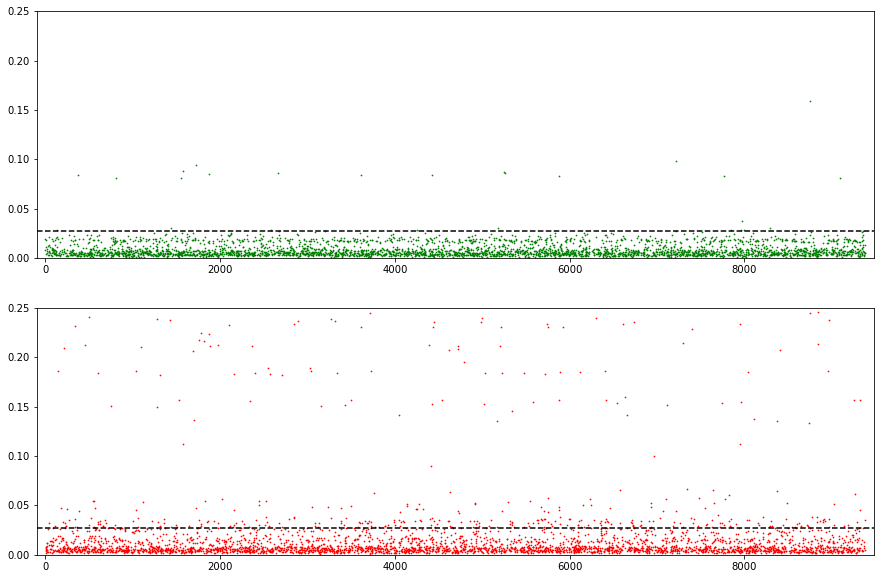

In [20]:
# 做出散点图。其中，虚线表示阈值。
plt.figure(figsize=(15, 10))
plt.subplot(2, 1, 1)
plt.scatter(npNormalX % nTotalLen, npNormalScores, c="green", s=0.5)
plt.hlines(fThreshold, xmin=-100, xmax=nTotalLen + 100, linestyles="dashed")
plt.xlim([-100, nTotalLen + 100])
plt.ylim([0, 0.25])

plt.subplot(2, 1, 2)
plt.scatter(npAbnormalX % nTotalLen, npAbnormalScores, c="red", s=0.5)
plt.hlines(fThreshold, xmin=-100, xmax=nTotalLen + 100, linestyles="dashed")
plt.xlim([-100, nTotalLen + 100])
plt.ylim([0, 0.25])
plt.show()

## 载波同步

### 构造建立模型

9个属性

In [375]:
class GANcarrier(object):
    def __init__(self):
        self.fn_makeGenerator()
        self.fn_makeDiscriminator()
        
    def fn_makeGenerator(self):
        self.oSeqGe = tf.keras.Sequential(name="Ge")
        self.oSeqGe.add(tf.keras.Input(shape=(9,)))
        self.oSeqGe.add(tf.keras.layers.Dense(7, kernel_initializer="he_normal"))
        self.oSeqGe.add(tf.keras.layers.LeakyReLU())
        self.oSeqGe.add(tf.keras.layers.BatchNormalization())
        self.oSeqGe.add(tf.keras.layers.Dense(7, kernel_initializer="he_normal"))
        self.oSeqGe.add(tf.keras.layers.LeakyReLU())

        self.oSeqGd = tf.keras.Sequential(name="Gd")
        self.oSeqGd.add(tf.keras.Input(shape=(7,)))
        self.oSeqGd.add(tf.keras.layers.Dense(7, kernel_initializer="he_normal"))
        self.oSeqGd.add(tf.keras.layers.LeakyReLU())
        self.oSeqGd.add(tf.keras.layers.BatchNormalization())
        self.oSeqGd.add(tf.keras.layers.Dense(9, activation = tf.keras.activations.sigmoid))
        
        self.oSeqGe1 = tf.keras.Sequential(name="Ge1")
        self.oSeqGe1.add(tf.keras.Input(shape=(9,)))
        self.oSeqGe1.add(tf.keras.layers.Dense(7, kernel_initializer="he_normal"))
        self.oSeqGe1.add(tf.keras.layers.LeakyReLU())
        self.oSeqGe1.add(tf.keras.layers.BatchNormalization())
        self.oSeqGe1.add(tf.keras.layers.Dense(7, kernel_initializer="he_normal"))
        self.oSeqGe1.add(tf.keras.layers.LeakyReLU())
        
    def fn_makeDiscriminator(self):
        self.oSeqDInner = tf.keras.Sequential(name="DInner")
        self.oSeqDInner.add(tf.keras.Input(shape=(9,)))
        self.oSeqDInner.add(tf.keras.layers.Dense(7, kernel_initializer="he_normal"))
        self.oSeqDInner.add(tf.keras.layers.LeakyReLU())
        self.oSeqDInner.add(tf.keras.layers.BatchNormalization())
        self.oSeqDInner.add(tf.keras.layers.Dense(7, kernel_initializer="he_normal"))
        self.oSeqDInner.add(tf.keras.layers.LeakyReLU())
        self.oSeqDInner.add(tf.keras.layers.BatchNormalization())

        self.oSeqD = tf.keras.Sequential([
            self.oSeqDInner,
            tf.keras.layers.Dense(1, activation = tf.keras.activations.sigmoid)
        ], name="D")

In [390]:
# 新建模型
tf.keras.backend.clear_session()
oGANcarrier = GANcarrier()

### 构造数据集

In [389]:
g_nFeatures = 9
g_nBatchSize = 256

def fn_splitCsvLine(strLine):
    tensorDefs = [0.] * g_nFeatures
    tensorRecord = tf.io.decode_csv(strLine, record_defaults=tensorDefs)
    tensorX = tf.stack(tensorRecord)
    return tensorX


oDataset = tf.data.Dataset.list_files(strJobsDir + "/*/*/parts/sync/carrier/samples/normal/train/preprocessed/samples.csv")
oDataset = oDataset.interleave(lambda strSamplesFile: tf.data.TextLineDataset(strSamplesFile).skip(1), \
                              cycle_length=5, num_parallel_calls=5)
oDataset = oDataset.map(fn_splitCsvLine, g_nFeatures)
oDataset = oDataset.shuffle(1000)
oDataset = oDataset.batch(g_nBatchSize)

In [391]:
# 读入所有的训练样本，从而通过shape属性得到训练集大小，存入全局变量中
listPreprocessedNormalTrainingSamples = []
for strJob in os.listdir(strJobsDir):
    strJobDir = os.path.join(strJobsDir, strJob)
    listDemodDirs = fn_getDemodDirsOfAJob(strJobDir)
    for strDemodDir in listDemodDirs:
        strPreprocessedNormalTrainingSamplesFile = os.path.join(strDemodDir, \
                                                   "parts/sync/carrier/samples/normal/train/preprocessed/samples.csv")
        pdDfPreprocessedNormalTrainingSamples = pd.read_csv(strPreprocessedNormalTrainingSamplesFile)
        listPreprocessedNormalTrainingSamples.append(pdDfPreprocessedNormalTrainingSamples)
pdDfPreprocessedNormalTrainingSamples = pd.concat(listPreprocessedNormalTrainingSamples)
g_tensorNormalTrainingSamples = tf.constant(pdDfPreprocessedNormalTrainingSamples.values, dtype=tf.float32)
g_nTrainingSize = len(g_tensorNormalTrainingSamples)

### 训练

In [392]:
# g_nTrainingSize在中频控制已经设置好了
g_nEpochs = 300
nSteps = g_nEpochs * g_nTrainingSize // g_nBatchSize
oExponentialDecay = tf.keras.optimizers.schedules.ExponentialDecay(1e-2, nSteps, 1e-1)
oOptimizerG = tf.keras.optimizers.Adam(learning_rate=oExponentialDecay)
oOptimizerD = tf.keras.optimizers.SGD(learning_rate=oExponentialDecay)

In [393]:
# 构造日志
strPrefix = datetime.datetime.now().strftime("%H_%M_%S")
strPrefix = "{}".format(strPrefix)
oSummaryWriterDLoss = tf.summary.create_file_writer("logs/carrier/" + strPrefix + "_D")
oSummaryWriterALoss = tf.summary.create_file_writer("logs/carrier/" + strPrefix + "_A")

In [394]:
oSeqGe, oSeqGd, oSeqGe1 = fn_train(oGANcarrier)

2020-02-21 21:35:10.872084
299/300

In [395]:
oSeqGe.save("models/sync/carrier/Ge.h5")
oSeqGd.save("models/sync/carrier/Gd.h5")
oSeqGe1.save("models/sync/carrier/Ge1.h5")

### 评估

In [85]:
oSeqGe = tf.keras.models.load_model("models/sync/carrier/Ge.h5")
oSeqD = tf.keras.models.load_model("models/sync/carrier/Gd.h5")
oSeqGe1 = tf.keras.models.load_model("models/sync/carrier/Ge1.h5")

In [86]:
# Test samples
for strJob in os.listdir("../jobs"):
    listDemodDirs = fn_getDemodDirsOfAJob(os.path.join(strJobsDir, strJob))
    for strDemodDir in listDemodDirs:
        strPreprocessedSamplesDir = os.path.join(strDemodDir, "parts/sync/carrier/samples/normal/test/preprocessed")
        strPreprocessedSamplesFile = os.path.join(strPreprocessedSamplesDir, "samples.csv")
        pdDfPreprocessedSamples = pd.read_csv(strPreprocessedSamplesFile, index_col="RECTIME")
        # 分数csv包含scores列
        pdDfScores = fn_score(pdDfPreprocessedSamples, oSeqGe, oSeqD, \
                              oSeqGe1)
        # 下面再csv里面添加id_num
        strDemod = os.path.split(strDemodDir)[1]
        pdSeriesId = pd.Series(data=pdDfScores.index, name="id")
        pdSeriesId = pdSeriesId.apply(lambda id: crc32(str.encode(strDemod + id)))
        pdDfScores["id"] = pdSeriesId.values
        strScoresFile = os.path.join(strPreprocessedSamplesDir, "scores.csv")
        pdDfScores.to_csv(strScoresFile, index_label="RECTIME")
        
# Abnormal samples
for strJob in os.listdir("../jobs"):
    listDemodDirs = fn_getDemodDirsOfAJob(os.path.join(strJobsDir, strJob))
    for strDemodDir in listDemodDirs:
        strPreprocessedSamplesDir = os.path.join(strDemodDir, "parts/sync/carrier/samples/abnormal/preprocessed")
        strPreprocessedSamplesFile = os.path.join(strPreprocessedSamplesDir, "samples.csv")
        pdDfPreprocessedSamples = pd.read_csv(strPreprocessedSamplesFile, index_col="RECTIME")
        pdDfScores = fn_score(pdDfPreprocessedSamples, oSeqGe, oSeqD, \
                              oSeqGe1)
        # 下面再csv里面添加id_num
        # 用解调器名和分数对应的RECTIME组合成一个大的字符串，然后对这个大的字符串进行crc32编码，编出一个独一无二的大整数
        strDemod = os.path.split(strDemodDir)[1]
        pdSeriesId = pd.Series(data=pdDfScores.index, name="id")
        pdSeriesId = pdSeriesId.apply(lambda id: crc32(str.encode(strDemod + id)))
        pdDfScores["id"] = pdSeriesId.values
        strScoresFile = os.path.join(strPreprocessedSamplesDir, "scores.csv")
        pdDfScores.to_csv(strScoresFile, index_label="RECTIME")

In [21]:
# 读入正常测试样本和异常测试样本的分数，分别存入numpy数组
listScores = []
listX = []
for strJob in os.listdir(strJobsDir):
    strJobDir = os.path.join(strJobsDir, strJob)
    listDemodDirs = fn_getDemodDirsOfAJob(strJobDir)
    for strDemodDir in listDemodDirs:
        strNormalTestingScoresFile = os.path.join(strDemodDir, \
                                                  "parts/sync/carrier/samples/normal/test/preprocessed/scores.csv")
        pdDfNormalTestingScores = pd.read_csv(strNormalTestingScoresFile, index_col="RECTIME")
        if not pdDfNormalTestingScores.empty:
            listScores.append(pdDfNormalTestingScores["scores"].values)
            # 分数的横坐标
            listX.append(pdDfNormalTestingScores["id"].values)
npNormalScores = np.concatenate(listScores)
npNormalX = np.concatenate(listX)

listScores = []
listX = []
for strJob in os.listdir(strJobsDir):
    strJobDir = os.path.join(strJobsDir, strJob)
    listDemodDirs = fn_getDemodDirsOfAJob(strJobDir)
    for strDemodDir in listDemodDirs:
        strAbnormalTestingScoresFile = os.path.join(strDemodDir, \
                                                  "parts/sync/carrier/samples/abnormal/preprocessed/scores.csv")
        pdDfAbnormalTestingScores = pd.read_csv(strAbnormalTestingScoresFile, index_col="RECTIME")
        if not pdDfAbnormalTestingScores.empty:
            listScores.append(pdDfAbnormalTestingScores["scores"].values)
            # 分数的横坐标
            listX.append(pdDfAbnormalTestingScores["id"].values)
npAbnormalScores = np.concatenate(listScores)
npAbnormalX = np.concatenate(listX)

In [22]:
nTotalLen = npNormalX.shape[0] + npAbnormalX.shape[0]

In [23]:
# 将正常测试样本的最大分数作为阈值，如果异常测试样本的分数大于该值则判错，小于判对
fThreshold = np.sort(npNormalScores)[int(len(npNormalScores) * 0.99)]

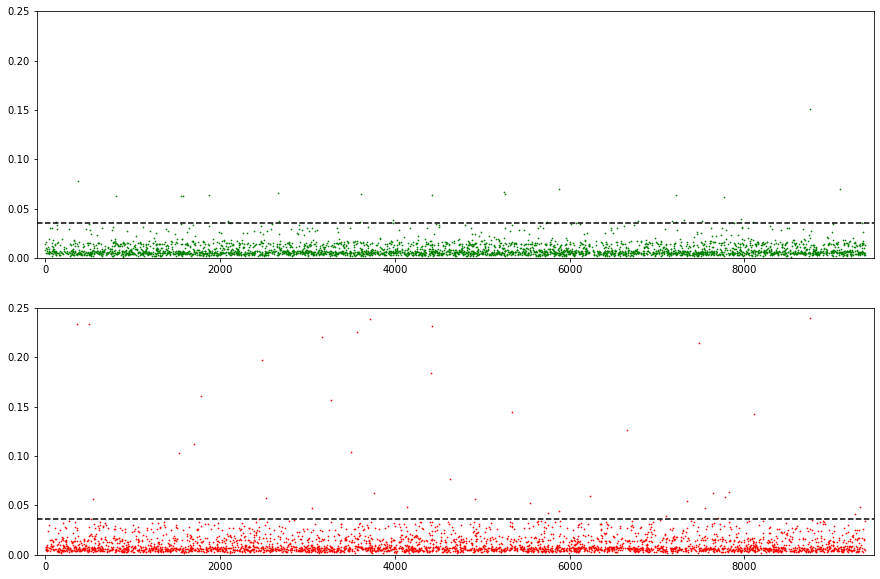

In [24]:
# 做出散点图。其中，虚线表示阈值。
plt.figure(figsize=(15, 10))
plt.subplot(2, 1, 1)
plt.scatter(npNormalX % nTotalLen, npNormalScores, c="green", s=0.5)
plt.hlines(fThreshold, xmin=-100, xmax=nTotalLen + 100, linestyles="dashed")
plt.xlim([-100, nTotalLen + 100])
plt.ylim([0, 0.25])

plt.subplot(2, 1, 2)
plt.scatter(npAbnormalX % nTotalLen, npAbnormalScores, c="red", s=0.5)
plt.hlines(fThreshold, xmin=-100, xmax=nTotalLen + 100, linestyles="dashed")
plt.xlim([-100, nTotalLen + 100])
plt.ylim([0, 0.25])
plt.show()

## 比特同步

### 构造建立模型
14个属性

In [401]:
class GANbit(object):
    def __init__(self):
        self.fn_makeGenerator()
        self.fn_makeDiscriminator()
        
    def fn_makeGenerator(self):
        self.oSeqGe = tf.keras.Sequential(name="Ge")
        self.oSeqGe.add(tf.keras.Input(shape=(14,)))
        self.oSeqGe.add(tf.keras.layers.Dense(10, kernel_initializer="he_normal"))
        self.oSeqGe.add(tf.keras.layers.LeakyReLU())
        self.oSeqGe.add(tf.keras.layers.BatchNormalization())
        self.oSeqGe.add(tf.keras.layers.Dense(10, kernel_initializer="he_normal"))
        self.oSeqGe.add(tf.keras.layers.LeakyReLU())

        self.oSeqGd = tf.keras.Sequential(name="Gd")
        self.oSeqGd.add(tf.keras.Input(shape=(10,)))
        self.oSeqGd.add(tf.keras.layers.Dense(10, kernel_initializer="he_normal"))
        self.oSeqGd.add(tf.keras.layers.LeakyReLU())
        self.oSeqGd.add(tf.keras.layers.BatchNormalization())
        self.oSeqGd.add(tf.keras.layers.Dense(14, activation = tf.keras.activations.sigmoid))
        
        self.oSeqGe1 = tf.keras.Sequential(name="Ge1")
        self.oSeqGe1.add(tf.keras.Input(shape=(14,)))
        self.oSeqGe1.add(tf.keras.layers.Dense(10, kernel_initializer="he_normal"))
        self.oSeqGe1.add(tf.keras.layers.LeakyReLU())
        self.oSeqGe1.add(tf.keras.layers.BatchNormalization())
        self.oSeqGe1.add(tf.keras.layers.Dense(10, kernel_initializer="he_normal"))
        self.oSeqGe1.add(tf.keras.layers.LeakyReLU())
        
    def fn_makeDiscriminator(self):
        self.oSeqDInner = tf.keras.Sequential(name="DInner")
        self.oSeqDInner.add(tf.keras.Input(shape=(14,)))
        self.oSeqDInner.add(tf.keras.layers.Dense(10, kernel_initializer="he_normal"))
        self.oSeqDInner.add(tf.keras.layers.LeakyReLU())
        self.oSeqDInner.add(tf.keras.layers.BatchNormalization())
        self.oSeqDInner.add(tf.keras.layers.Dense(10, kernel_initializer="he_normal"))
        self.oSeqDInner.add(tf.keras.layers.LeakyReLU())
        self.oSeqDInner.add(tf.keras.layers.BatchNormalization())

        self.oSeqD = tf.keras.Sequential([
            self.oSeqDInner,
            tf.keras.layers.Dense(1, activation = tf.keras.activations.sigmoid)
        ], name="D")

In [402]:
# 新建模型
tf.keras.backend.clear_session()
oGANbit = GANbit()

### 构造数据集

In [403]:
g_nFeatures = 14
g_nBatchSize = 256

def fn_splitCsvLine(strLine):
    tensorDefs = [0.] * g_nFeatures
    tensorRecord = tf.io.decode_csv(strLine, record_defaults=tensorDefs)
    tensorX = tf.stack(tensorRecord)
    return tensorX

oDataset = tf.data.Dataset.list_files(strJobsDir + "/*/*/parts/sync/bit/samples/normal/train/preprocessed/samples.csv")
oDataset = oDataset.interleave(lambda strSamplesFile: tf.data.TextLineDataset(strSamplesFile).skip(1), \
                              cycle_length=5, num_parallel_calls=5)
oDataset = oDataset.map(fn_splitCsvLine, g_nFeatures)
oDataset = oDataset.shuffle(1000)
oDataset = oDataset.batch(g_nBatchSize)

In [405]:
# 读入所有的训练样本，从而通过shape属性得到训练集大小，存入全局变量中
listPreprocessedNormalTrainingSamples = []
for strJob in os.listdir(strJobsDir):
    strJobDir = os.path.join(strJobsDir, strJob)
    listDemodDirs = fn_getDemodDirsOfAJob(strJobDir)
    for strDemodDir in listDemodDirs:
        strPreprocessedNormalTrainingSamplesFile = os.path.join(strDemodDir, \
                                                   "parts/sync/bit/samples/normal/train/preprocessed/samples.csv")
        pdDfPreprocessedNormalTrainingSamples = pd.read_csv(strPreprocessedNormalTrainingSamplesFile)
        listPreprocessedNormalTrainingSamples.append(pdDfPreprocessedNormalTrainingSamples)
pdDfPreprocessedNormalTrainingSamples = pd.concat(listPreprocessedNormalTrainingSamples)
g_tensorNormalTrainingSamples = tf.constant(pdDfPreprocessedNormalTrainingSamples.values, dtype=tf.float32)
g_nTrainingSize = len(g_tensorNormalTrainingSamples)

### 训练

In [406]:
# g_nTrainingSize在中频控制已经设置好了
g_nEpochs = 400
nSteps = g_nEpochs * g_nTrainingSize // g_nBatchSize
oExponentialDecay = tf.keras.optimizers.schedules.ExponentialDecay(1e-2, nSteps, 1e-1)
oOptimizerG = tf.keras.optimizers.Adam(learning_rate=oExponentialDecay)
oOptimizerD = tf.keras.optimizers.SGD(learning_rate=oExponentialDecay)

In [407]:
# 构造日志
strPrefix = datetime.datetime.now().strftime("%H_%M_%S")
strPrefix = "{}".format(strPrefix)
oSummaryWriterDLoss = tf.summary.create_file_writer("logs/bit/" + strPrefix + "_D")
oSummaryWriterALoss = tf.summary.create_file_writer("logs/bit/" + strPrefix + "_A")

In [408]:
oSeqGe, oSeqGd, oSeqGe1 = fn_train(oGANbit)

2020-02-21 22:08:55.557098
399/400

In [409]:
oSeqGe.save("models/sync/bit/Ge.h5")
oSeqGd.save("models/sync/bit/Gd.h5")
oSeqGe1.save("models/sync/bit/Ge1.h5")

### 评估

In [91]:
oSeqGe = tf.keras.models.load_model("models/sync/bit/Ge.h5")
oSeqD = tf.keras.models.load_model("models/sync/bit/Gd.h5")
oSeqGe1 = tf.keras.models.load_model("models/sync/bit/Ge1.h5")

In [92]:
# Test samples
for strJob in os.listdir("../jobs"):
    listDemodDirs = fn_getDemodDirsOfAJob(os.path.join(strJobsDir, strJob))
    for strDemodDir in listDemodDirs:
        strPreprocessedSamplesDir = os.path.join(strDemodDir, "parts/sync/bit/samples/normal/test/preprocessed")
        strPreprocessedSamplesFile = os.path.join(strPreprocessedSamplesDir, "samples.csv")
        pdDfPreprocessedSamples = pd.read_csv(strPreprocessedSamplesFile, index_col="RECTIME")
        # 分数csv包含scores列
        pdDfScores = fn_score(pdDfPreprocessedSamples, oSeqGe, oSeqD, \
                              oSeqGe1)
        # 下面再csv里面添加id_num
        strDemod = os.path.split(strDemodDir)[1]
        pdSeriesId = pd.Series(data=pdDfScores.index, name="id")
        pdSeriesId = pdSeriesId.apply(lambda id: crc32(str.encode(strDemod + id)))
        pdDfScores["id"] = pdSeriesId.values
        strScoresFile = os.path.join(strPreprocessedSamplesDir, "scores.csv")
        pdDfScores.to_csv(strScoresFile, index_label="RECTIME")
        
# Abnormal samples
for strJob in os.listdir("../jobs"):
    listDemodDirs = fn_getDemodDirsOfAJob(os.path.join(strJobsDir, strJob))
    for strDemodDir in listDemodDirs:
        strPreprocessedSamplesDir = os.path.join(strDemodDir, "parts/sync/bit/samples/abnormal/preprocessed")
        strPreprocessedSamplesFile = os.path.join(strPreprocessedSamplesDir, "samples.csv")
        pdDfPreprocessedSamples = pd.read_csv(strPreprocessedSamplesFile, index_col="RECTIME")
        pdDfScores = fn_score(pdDfPreprocessedSamples, oSeqGe, oSeqD, \
                              oSeqGe1)
        # 下面再csv里面添加id_num
        # 用解调器名和分数对应的RECTIME组合成一个大的字符串，然后对这个大的字符串进行crc32编码，编出一个独一无二的大整数
        strDemod = os.path.split(strDemodDir)[1]
        pdSeriesId = pd.Series(data=pdDfScores.index, name="id")
        pdSeriesId = pdSeriesId.apply(lambda id: crc32(str.encode(strDemod + id)))
        pdDfScores["id"] = pdSeriesId.values
        strScoresFile = os.path.join(strPreprocessedSamplesDir, "scores.csv")
        pdDfScores.to_csv(strScoresFile, index_label="RECTIME")

In [25]:
# 读入正常测试样本和异常测试样本的分数，分别存入numpy数组
listScores = []
listX = []
for strJob in os.listdir(strJobsDir):
    strJobDir = os.path.join(strJobsDir, strJob)
    listDemodDirs = fn_getDemodDirsOfAJob(strJobDir)
    for strDemodDir in listDemodDirs:
        strNormalTestingScoresFile = os.path.join(strDemodDir, \
                                                  "parts/sync/bit/samples/normal/test/preprocessed/scores.csv")
        pdDfNormalTestingScores = pd.read_csv(strNormalTestingScoresFile, index_col="RECTIME")
        if not pdDfNormalTestingScores.empty:
            listScores.append(pdDfNormalTestingScores["scores"].values)
            # 分数的横坐标
            listX.append(pdDfNormalTestingScores["id"].values)
npNormalScores = np.concatenate(listScores)
npNormalX = np.concatenate(listX)

listScores = []
listX = []
for strJob in os.listdir(strJobsDir):
    strJobDir = os.path.join(strJobsDir, strJob)
    listDemodDirs = fn_getDemodDirsOfAJob(strJobDir)
    for strDemodDir in listDemodDirs:
        strAbnormalTestingScoresFile = os.path.join(strDemodDir, \
                                                  "parts/sync/bit/samples/abnormal/preprocessed/scores.csv")
        pdDfAbnormalTestingScores = pd.read_csv(strAbnormalTestingScoresFile, index_col="RECTIME")
        if not pdDfAbnormalTestingScores.empty:
            listScores.append(pdDfAbnormalTestingScores["scores"].values)
            # 分数的横坐标
            listX.append(pdDfAbnormalTestingScores["id"].values)
npAbnormalScores = np.concatenate(listScores)
npAbnormalX = np.concatenate(listX)

In [26]:
nTotalLen = npNormalX.shape[0] + npAbnormalX.shape[0]

In [29]:
# 将正常测试样本的最大分数作为阈值，如果异常测试样本的分数大于该值则判错，小于判对
fThreshold = np.sort(npNormalScores)[int(len(npNormalScores) * 0.99)]

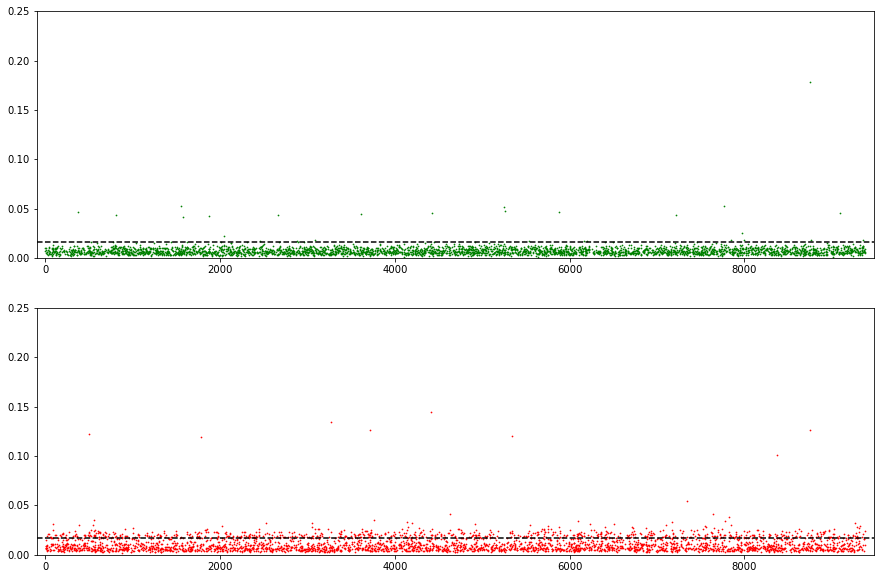

In [30]:
# 做出散点图。其中，虚线表示阈值。
plt.figure(figsize=(15, 10))
plt.subplot(2, 1, 1)
plt.scatter(npNormalX % nTotalLen, npNormalScores, c="green", s=0.5)
plt.hlines(fThreshold, xmin=-100, xmax=nTotalLen + 100, linestyles="dashed")
plt.xlim([-100, nTotalLen + 100])
plt.ylim([0, 0.25])

plt.subplot(2, 1, 2)
plt.scatter(npAbnormalX % nTotalLen, npAbnormalScores, c="red", s=0.5)
plt.hlines(fThreshold, xmin=-100, xmax=nTotalLen + 100, linestyles="dashed")
plt.xlim([-100, nTotalLen + 100])
plt.ylim([0, 0.25])
plt.show()

## 维特比译码

### 构造建立模型
18个属性

In [97]:
class GANvi(object):
    def __init__(self):
        self.fn_makeGenerator()
        self.fn_makeDiscriminator()
        
    def fn_makeGenerator(self):
        self.oSeqGe = tf.keras.Sequential(name="Ge")
        self.oSeqGe.add(tf.keras.Input(shape=(18,)))
        self.oSeqGe.add(tf.keras.layers.Dense(14, kernel_initializer="he_normal"))
        self.oSeqGe.add(tf.keras.layers.LeakyReLU())
        self.oSeqGe.add(tf.keras.layers.BatchNormalization())
        self.oSeqGe.add(tf.keras.layers.Dense(14, kernel_initializer="he_normal"))
        self.oSeqGe.add(tf.keras.layers.LeakyReLU())

        self.oSeqGd = tf.keras.Sequential(name="Gd")
        self.oSeqGd.add(tf.keras.Input(shape=(14,)))
        self.oSeqGd.add(tf.keras.layers.Dense(14, kernel_initializer="he_normal"))
        self.oSeqGd.add(tf.keras.layers.LeakyReLU())
        self.oSeqGd.add(tf.keras.layers.BatchNormalization())
        self.oSeqGd.add(tf.keras.layers.Dense(18, activation = tf.keras.activations.sigmoid))
        
        self.oSeqGe1 = tf.keras.Sequential(name="Ge1")
        self.oSeqGe1.add(tf.keras.Input(shape=(18,)))
        self.oSeqGe1.add(tf.keras.layers.Dense(14, kernel_initializer="he_normal"))
        self.oSeqGe1.add(tf.keras.layers.LeakyReLU())
        self.oSeqGe1.add(tf.keras.layers.BatchNormalization())
        self.oSeqGe1.add(tf.keras.layers.Dense(14, kernel_initializer="he_normal"))
        self.oSeqGe1.add(tf.keras.layers.LeakyReLU())
        
    def fn_makeDiscriminator(self):
        self.oSeqDInner = tf.keras.Sequential(name="DInner")
        self.oSeqDInner.add(tf.keras.Input(shape=(18,)))
        self.oSeqDInner.add(tf.keras.layers.Dense(14, kernel_initializer="he_normal"))
        self.oSeqDInner.add(tf.keras.layers.LeakyReLU())
        self.oSeqDInner.add(tf.keras.layers.BatchNormalization())
        self.oSeqDInner.add(tf.keras.layers.Dense(14, kernel_initializer="he_normal"))
        self.oSeqDInner.add(tf.keras.layers.LeakyReLU())
        self.oSeqDInner.add(tf.keras.layers.BatchNormalization())

        self.oSeqD = tf.keras.Sequential([
            self.oSeqDInner,
            tf.keras.layers.Dense(1, activation = tf.keras.activations.sigmoid)
        ], name="D")

In [108]:
# 新建模型
tf.keras.backend.clear_session()
oGANvi = GANvi()

### 构造数据集

In [99]:
g_nFeatures = 18
g_nBatchSize = 256

def fn_splitCsvLine(strLine):
    tensorDefs = [0.] * g_nFeatures
    tensorRecord = tf.io.decode_csv(strLine, record_defaults=tensorDefs)
    tensorX = tf.stack(tensorRecord)
    return tensorX

oDataset = tf.data.Dataset.list_files(strJobsDir + "/*/*/parts/sync/vi/*/samples/normal/train/preprocessed/samples.csv")
oDataset = oDataset.interleave(lambda strSamplesFile: tf.data.TextLineDataset(strSamplesFile).skip(1), \
                              cycle_length=5, num_parallel_calls=5)
oDataset = oDataset.map(fn_splitCsvLine, g_nFeatures)
oDataset = oDataset.shuffle(1000)
oDataset = oDataset.batch(g_nBatchSize)

In [112]:
# 读入所有的训练样本，从而通过shape属性得到训练集大小，存入全局变量中
# 由于对于分路情况，有I和Q两路样本，所以两路都要读
listPreprocessedNormalTrainingSamples = []
for strJob in os.listdir(strJobsDir):
    strJobDir = os.path.join(strJobsDir, strJob)
    listDemodDirs = fn_getDemodDirsOfAJob(strJobDir)
    for strDemodDir in listDemodDirs:
        # 读入控制文件，方便判断合路、分路 
        pdDfControl = pd.read_csv(os.path.join(strDemodDir, "control.csv"), index_col="RECTIME")
        # 设置部分的文件夹
        strSectionDir = os.path.join(strDemodDir, "parts/sync/vi")
        
        # 用dataframe的numpy值存入链表，再收尾连接。因为I和Q的属性名称的后缀不同，直接连接会出现Nan
        if pdDfControl["DEMOD_FRAMESYNCINPUT"][0] == 1:
            # 合路
            listPreprocessedNormalTrainingSamples.append(\
                 pd.read_csv(os.path.join(strSectionDir, "I/samples/normal/train/preprocessed/samples.csv")).values)
        else:
            # 分路
            listPreprocessedNormalTrainingSamples.append(\
                 pd.read_csv(os.path.join(strSectionDir, "I/samples/normal/train/preprocessed/samples.csv")).values)
            listPreprocessedNormalTrainingSamples.append(\
                 pd.read_csv(os.path.join(strSectionDir, "Q/samples/normal/train/preprocessed/samples.csv")).values)
pdDfPreprocessedNormalTrainingSamples = np.concatenate(listPreprocessedNormalTrainingSamples)
g_tensorNormalTrainingSamples = tf.constant(pdDfPreprocessedNormalTrainingSamples, dtype=tf.float32)
g_nTrainingSize = len(g_tensorNormalTrainingSamples)

### 训练

In [103]:
# g_nTrainingSize在中频控制已经设置好了
g_nEpochs = 400
nSteps = g_nEpochs * g_nTrainingSize // g_nBatchSize
oExponentialDecay = tf.keras.optimizers.schedules.ExponentialDecay(1e-2, nSteps, 1e-1)
oOptimizerG = tf.keras.optimizers.Adam(learning_rate=oExponentialDecay)
oOptimizerD = tf.keras.optimizers.SGD(learning_rate=oExponentialDecay)

In [114]:
# 构造日志
strPrefix = datetime.datetime.now().strftime("%H_%M_%S")
strPrefix = "{}".format(strPrefix)
oSummaryWriterDLoss = tf.summary.create_file_writer("logs/vi/" + strPrefix + "_D")
oSummaryWriterALoss = tf.summary.create_file_writer("logs/vi/" + strPrefix + "_A")

In [115]:
oSeqGe, oSeqGd, oSeqGe1 = fn_train(oGANvi)

2020-02-28 13:07:22.657416
399/400

In [117]:
oSeqGe.save("models/sync/vi/Ge.h5")
oSeqGd.save("models/sync/vi/Gd.h5")
oSeqGe1.save("models/sync/vi/Ge1.h5")

### 评估

In [118]:
oSeqGe = tf.keras.models.load_model("models/sync/vi/Ge.h5")
oSeqD = tf.keras.models.load_model("models/sync/vi/Gd.h5")
oSeqGe1 = tf.keras.models.load_model("models/sync/vi/Ge1.h5")

In [173]:
# 计算分数
def fn_scoresIOrQ():
    # test samples
    pdDfPreprocessedSamples = pd.read_csv(\
          os.path.join(strSamplesDir, "normal/test/preprocessed/samples.csv"), index_col="RECTIME")
    # 分数csv包含scores列
    pdDfScores = fn_score(pdDfPreprocessedSamples, oSeqGe, oSeqD, \
                          oSeqGe1)
    # 下面再csv里面添加id_num
    strDemod = os.path.split(strDemodDir)[1]
    pdSeriesId = pd.Series(data=pdDfScores.index, name="id")
    pdSeriesId = pdSeriesId.apply(lambda id: crc32(str.encode(strDemod + id)))
    pdDfScores["id"] = pdSeriesId.values
    
    pdDfScores.to_csv(os.path.join(strSamplesDir, "normal/test/preprocessed/scores.csv"), index_label="RECTIME")

    # Abnormal samples
    pdDfPreprocessedSamples = pd.read_csv(\
          os.path.join(strSamplesDir, "abnormal/preprocessed/samples.csv"), index_col="RECTIME")
    pdDfScores = fn_score(pdDfPreprocessedSamples, oSeqGe, oSeqD, \
                          oSeqGe1)
    # 下面再csv里面添加id_num
    # 用解调器名和分数对应的RECTIME组合成一个大的字符串，然后对这个大的字符串进行crc32编码，编出一个独一无二的大整数
    strDemod = os.path.split(strDemodDir)[1]
    pdSeriesId = pd.Series(data=pdDfScores.index, name="id")
    pdSeriesId = pdSeriesId.apply(lambda id: crc32(str.encode(strDemod + id)))
    pdDfScores["id"] = pdSeriesId.values
    pdDfScores.to_csv(os.path.join(strSamplesDir, "abnormal/preprocessed/scores.csv"), index_label="RECTIME")

for strJob in os.listdir(strJobsDir):
    listDemodDirs = fn_getDemodDirsOfAJob(os.path.join(strJobsDir, strJob))
    for strDemodDir in listDemodDirs:
        strSectionDir = os.path.join(strDemodDir, "parts/sync/vi")
        # 读入控制文件
        pdDfControl = pd.read_csv(os.path.join(strDemodDir, "control.csv"), index_col="RECTIME")
        
        if pdDfControl["DEMOD_FRAMESYNCINPUT"][0] == 1:
            #合路
            strSamplesDir = os.path.join(strSectionDir, "I/samples")
            fn_scoresIOrQ()
        else:
            # 分路
            strSamplesDir = os.path.join(strSectionDir, "I/samples")
            fn_scoresIOrQ()
            strSamplesDir = os.path.join(strSectionDir, "Q/samples")
            fn_scoresIOrQ()

In [31]:
# 读取分数
# 需要读入每个分路正常测试样本的I路和Q路的分数，用于计算阈值
# 只用读入每个异常测试样本的I路分数用于作图。由于异常测试样本的I路和Q路帧同步锁均没锁上，所以分路的异常测试样本的I路一定
# 没有锁上。而且这样一来，用于作图的异常测试样本基本和分路之前的各个部分保持相同，更有利于看出图的变化
listScores = []
listX = []
for strJob in os.listdir(strJobsDir):
    listDemodDirs = fn_getDemodDirsOfAJob(os.path.join(strJobsDir, strJob))
    for strDemodDir in listDemodDirs:
        pdDfControl = pd.read_csv(os.path.join(strDemodDir, "control.csv"), index_col="RECTIME")
        strSectionDir = os.path.join(strDemodDir, "parts/sync/vi")
        
        if pdDfControl["DEMOD_FRAMESYNCINPUT"][0] == 1:
            # 合路
            pdDfNormalTestingScores = pd.read_csv(os.path.join(strSectionDir, \
               "I/samples/normal/test/preprocessed/scores.csv"), index_col="RECTIME")
            listScores.append(pdDfNormalTestingScores["scores"].values)
            listX.append(pdDfNormalTestingScores["id"].values)
        else:
            # 合路
            pdDfNormalTestingScores = pd.read_csv(os.path.join(strSectionDir, \
               "I/samples/normal/test/preprocessed/scores.csv"), index_col="RECTIME")
            listScores.append(pdDfNormalTestingScores["scores"].values)
            listX.append(pdDfNormalTestingScores["id"].values)
            
            pdDfNormalTestingScores = pd.read_csv(os.path.join(strSectionDir, \
               "Q/samples/normal/test/preprocessed/scores.csv"), index_col="RECTIME")
            listScores.append(pdDfNormalTestingScores["scores"].values)
            listX.append(pdDfNormalTestingScores["id"].values)
npNormalScores = np.concatenate(listScores)
npNormalX = np.concatenate(listX)

# 异常样本
listScores = []
listX = []
for strJob in os.listdir(strJobsDir):
    listDemodDirs = fn_getDemodDirsOfAJob(os.path.join(strJobsDir, strJob))
    for strDemodDir in listDemodDirs:
        strSectionDir = os.path.join(strDemodDir, "parts/sync/vi")
        
        pdDfAbnormalTestingScores = pd.read_csv(os.path.join(strSectionDir, \
           "I/samples/abnormal/preprocessed/scores.csv"), index_col="RECTIME")
        listScores.append(pdDfAbnormalTestingScores["scores"].values)
        listX.append(pdDfAbnormalTestingScores["id"].values)
npAbnormalScores = np.concatenate(listScores)
npAbnormalX = np.concatenate(listX)

In [32]:
nTotalLen = npNormalX.shape[0] + npAbnormalX.shape[0]

In [33]:
# 将正常测试样本的最大分数作为阈值，如果异常测试样本的分数大于该值则判错，小于判对
fThreshold = np.sort(npNormalScores)[int(len(npNormalScores) * 0.98)]

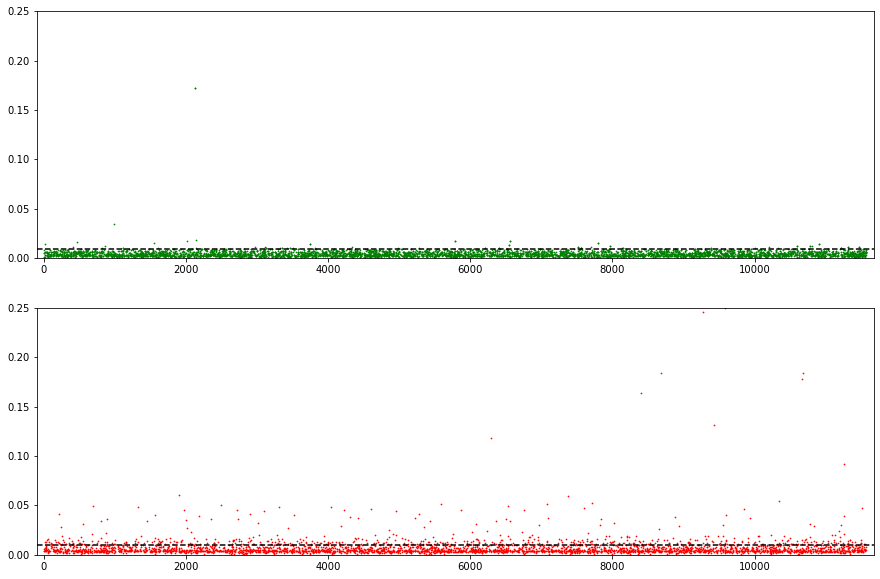

In [34]:
# 做出散点图。其中，虚线表示阈值。
plt.figure(figsize=(15, 10))
plt.subplot(2, 1, 1)
plt.scatter(npNormalX % nTotalLen, npNormalScores, c="green", s=0.5)
plt.hlines(fThreshold, xmin=-100, xmax=nTotalLen + 100, linestyles="dashed")
plt.xlim([-100, nTotalLen + 100])
plt.ylim([0, 0.25])

plt.subplot(2, 1, 2)
plt.scatter(npAbnormalX % nTotalLen, npAbnormalScores, c="red", s=0.5)
plt.hlines(fThreshold, xmin=-100, xmax=nTotalLen + 100, linestyles="dashed")
plt.xlim([-100, nTotalLen + 100])
plt.ylim([0, 0.25])
plt.show()

## 帧同步

### 构造建立模型
24个属性

In [289]:
class GANframe(object):
    def __init__(self):
        self.fn_makeGenerator()
        self.fn_makeDiscriminator()
        
    def fn_makeGenerator(self):
        self.oSeqGe = tf.keras.Sequential(name="Ge")
        self.oSeqGe.add(tf.keras.Input(shape=(24,)))
        self.oSeqGe.add(tf.keras.layers.Dense(22, kernel_initializer="he_normal"))
        self.oSeqGe.add(tf.keras.layers.LeakyReLU())
        self.oSeqGe.add(tf.keras.layers.BatchNormalization())
        self.oSeqGe.add(tf.keras.layers.Dense(22, kernel_initializer="he_normal"))
        self.oSeqGe.add(tf.keras.layers.LeakyReLU())

        self.oSeqGd = tf.keras.Sequential(name="Gd")
        self.oSeqGd.add(tf.keras.Input(shape=(22,)))
        self.oSeqGd.add(tf.keras.layers.Dense(22, kernel_initializer="he_normal"))
        self.oSeqGd.add(tf.keras.layers.LeakyReLU())
        self.oSeqGd.add(tf.keras.layers.BatchNormalization())
        # 原来的输出层
#        self.oSeqGd.add(tf.keras.layers.Dense(24, activation = tf.keras.activations.sigmoid))
        # 该成tanh
        self.oSeqGd.add(tf.keras.layers.Dense(24, kernel_initializer="he_normal", activation="tanh"))

        
        self.oSeqGe1 = tf.keras.Sequential(name="Ge1")
        self.oSeqGe1.add(tf.keras.Input(shape=(24,)))
        self.oSeqGe1.add(tf.keras.layers.Dense(22, kernel_initializer="he_normal"))
        self.oSeqGe1.add(tf.keras.layers.LeakyReLU())
        self.oSeqGe1.add(tf.keras.layers.BatchNormalization())
        self.oSeqGe1.add(tf.keras.layers.Dense(22, kernel_initializer="he_normal"))
        self.oSeqGe1.add(tf.keras.layers.LeakyReLU())
    def fn_makeDiscriminator(self):
        self.oSeqDInner = tf.keras.Sequential(name="DInner")
        self.oSeqDInner.add(tf.keras.Input(shape=(24,)))
        self.oSeqDInner.add(tf.keras.layers.Dense(22, kernel_initializer="he_normal"))
        self.oSeqDInner.add(tf.keras.layers.LeakyReLU())
        self.oSeqDInner.add(tf.keras.layers.BatchNormalization())
        self.oSeqDInner.add(tf.keras.layers.Dense(22, kernel_initializer="he_normal"))
        self.oSeqDInner.add(tf.keras.layers.LeakyReLU())
        self.oSeqDInner.add(tf.keras.layers.BatchNormalization())

        self.oSeqD = tf.keras.Sequential([
            self.oSeqDInner,
            tf.keras.layers.Dense(1, activation = tf.keras.activations.sigmoid)
        ], name="D")

In [290]:
# 新建模型
tf.keras.backend.clear_session()
oGANframe = GANframe()

### 构造数据集

In [291]:
g_nFeatures = 24
g_nBatchSize = 256

def fn_splitCsvLine(strLine):
    tensorDefs = [0.] * g_nFeatures
    tensorRecord = tf.io.decode_csv(strLine, record_defaults=tensorDefs)
    tensorX = tf.stack(tensorRecord)
    return tensorX

oDataset = tf.data.Dataset.list_files(strJobsDir + "/*/*/parts/sync/frame/*/samples/normal/train/preprocessed/samples.csv")
oDataset = oDataset.interleave(lambda strSamplesFile: tf.data.TextLineDataset(strSamplesFile).skip(1), \
                              cycle_length=5, num_parallel_calls=5)
oDataset = oDataset.map(fn_splitCsvLine, g_nFeatures)
oDataset = oDataset.shuffle(1000)
oDataset = oDataset.batch(g_nBatchSize)

In [256]:
# 读入所有的训练样本，从而通过shape属性得到训练集大小，存入全局变量中，并且要用于每次迭代结束后计算总的损失，从而求得最佳模型
# 由于对于分路情况，有I和Q两路样本，所以两路都要读
listPreprocessedNormalTrainingSamples = []
for strJob in os.listdir(strJobsDir):
    strJobDir = os.path.join(strJobsDir, strJob)
    listDemodDirs = fn_getDemodDirsOfAJob(strJobDir)
    for strDemodDir in listDemodDirs:
        # 读入控制文件，方便判断合路、分路 
        pdDfControl = pd.read_csv(os.path.join(strDemodDir, "control.csv"), index_col="RECTIME")
        # 设置部分的文件夹
        strSectionDir = os.path.join(strDemodDir, "parts/sync/frame")
        
        # 用dataframe的numpy值存入链表，再收尾连接。因为I和Q的属性名称的后缀不同，直接连接会出现Nan
        if pdDfControl["DEMOD_FRAMESYNCINPUT"][0] == 1:
            # 合路
            listPreprocessedNormalTrainingSamples.append(\
                 pd.read_csv(os.path.join(strSectionDir, "I/samples/normal/train/preprocessed/samples.csv")).values)
        else:
            # 分路
            listPreprocessedNormalTrainingSamples.append(\
                 pd.read_csv(os.path.join(strSectionDir, "I/samples/normal/train/preprocessed/samples.csv")).values)
            listPreprocessedNormalTrainingSamples.append(\
                 pd.read_csv(os.path.join(strSectionDir, "Q/samples/normal/train/preprocessed/samples.csv")).values)
pdDfPreprocessedNormalTrainingSamples = np.concatenate(listPreprocessedNormalTrainingSamples)
g_tensorNormalTrainingSamples = tf.constant(pdDfPreprocessedNormalTrainingSamples, dtype=tf.float32)
g_nTrainingSize = len(g_tensorNormalTrainingSamples)

### 训练

In [292]:
g_nEpochs = 400
nSteps = g_nEpochs * g_nTrainingSize // g_nBatchSize
oExponentialDecay = tf.keras.optimizers.schedules.ExponentialDecay(1e-2, nSteps, 1e-1)
oOptimizerG = tf.keras.optimizers.Adam(learning_rate=oExponentialDecay)
oOptimizerD = tf.keras.optimizers.SGD(learning_rate=oExponentialDecay)

In [293]:
# 构造日志
strPrefix = datetime.datetime.now().strftime("%H_%M_%S")
strPrefix = "{}".format("noflip_tanh_24_22")
oSummaryWriterDLoss = tf.summary.create_file_writer("logs/frame/" + strPrefix + "_D")
oSummaryWriterALoss = tf.summary.create_file_writer("logs/frame/" + strPrefix + "_A")

In [294]:
def fn_train(oGAN): 
    def fn_getGLoss(tensorInput):
        # Apperant loss
        tensorEncodedSamples = oGAN.oSeqGe(tensorInput)
        tensorFakeSamples = oGAN.oSeqGd(tensorEncodedSamples)
        tensorApperantLoss = tf.reduce_mean(tf.losses.mean_absolute_error(tensorInput, tensorFakeSamples))

        # Latent loss
        tensorEncoded1Samples = oGAN.oSeqGe1(tensorFakeSamples)
        tensorLatentLoss = \
        tf.reduce_mean(tf.losses.mean_squared_error(tensorEncodedSamples, tensorEncoded1Samples))

        # Feature matching loss
        tensorPredFeatures = oGAN.oSeqDInner(tensorFakeSamples)
        tensorTrueFeatures = oGAN.oSeqDInner(tensorInput)
        tensorFeatureLoss = tf.reduce_mean(tf.losses.mean_squared_error(tensorPredFeatures, tensorTrueFeatures))

        tensorGLoss = tensorApperantLoss + tensorLatentLoss + tensorFeatureLoss
        return tensorGLoss
    # 在每个epoch后存储最小的ALoss和对应的
    fGLossLast = np.inf
    # 存储生成器的解码器和译码器
    oSeqLastGe = None
    oSeqLastGd = None
    oSeqLastGe1 = None
    # 开始训练，输出训练的开始时间和训练的结束时间
    nStep = 0
    print(datetime.datetime.now())
    for nEpoch in range(g_nEpochs):
        for tensorBatch in oDataset:
            # Train discriminator
            # Generator fake samples
            tensorEncodedSamples = oGAN.oSeqGe(tensorBatch)
            tensorFakeSamples = oGAN.oSeqGd(tensorEncodedSamples)
            with tf.GradientTape() as oGradientTapeD:
                # Train discriminator with real samples
                npNArrLabels = np.random.uniform(low=0.7, high=1.2, size=(tensorBatch.shape[0], 1))
                """
                #occasionaly flip the labels
                nFlipLen = int(0.05 * npNArrLabels.shape[0])
                npIndexes = np.random.randint(low=0, high=npNArrLabels.shape[0], size=nFlipLen)
                npNArrLabels[npIndexes, 0] = np.random.uniform(low=0, high=0.3, size=nFlipLen)     
                """
                tensorLabels = tf.constant(npNArrLabels, dtype=tf.float32)

                tensorPreds = oGAN.oSeqD(tensorBatch)
                tensorDLossR = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(tensorLabels, tensorPreds))
            listDGradients = oGradientTapeD.gradient(tensorDLossR, oGAN.oSeqD.trainable_variables)
            oOptimizerD.apply_gradients(zip(listDGradients, oGAN.oSeqD.trainable_variables))
            with tf.GradientTape() as oGradientTapeD:
               # Train discriminator with fake samples
                npNArrLabels = np.random.uniform(low=0., high=0.3, size=(tensorFakeSamples.shape[0], 1))
                """
                # occasionaly flip the labels
                #nFlipLen = int(0.05 * npNArrLabels.shape[0])
                #npIndexes = np.random.randint(low=0, high=npNArrLabels.shape[0], size=nFlipLen)
                #npNArrLabels[npIndexes, 0] = np.random.uniform(low=0.7, high=1.2, size=nFlipLen)     
                """
                tensorLabels = tf.constant(npNArrLabels, dtype=tf.float32)
                
                tensorPreds = oGAN.oSeqD(tensorFakeSamples)
                tensorDLossF = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(tensorLabels, tensorPreds))
            listDGradients = oGradientTapeD.gradient(tensorDLossF, oGAN.oSeqD.trainable_variables)
            oOptimizerD.apply_gradients(zip(listDGradients, oGAN.oSeqD.trainable_variables))
            tensorDLoss = tensorDLossR + tensorDLossF
            with oSummaryWriterDLoss.as_default():
                tf.summary.scalar("D_Loss", tensorDLoss, nStep)

            # Train genertor
            with tf.GradientTape() as oGradientTapeG:
                tensorGLoss = fn_getGLoss(tensorBatch)
            # Insert all generator trainable variables into a list
            listTrainableGVariables = []
            listTrainableGVariables.extend(oGAN.oSeqGe.trainable_variables)
            listTrainableGVariables.extend(oGAN.oSeqGd.trainable_variables)
            listTrainableGVariables.extend(oGAN.oSeqGe1.trainable_variables)

            listGGradients = oGradientTapeG.gradient(tensorGLoss, listTrainableGVariables)
            oOptimizerG.apply_gradients(zip(listGGradients, listTrainableGVariables))
            with oSummaryWriterALoss.as_default():
                tf.summary.scalar("A_loss", tensorGLoss, nStep)

            nStep = nStep + 1
            
        # 在整个训练集上计算generator的损失，并比较和上一次迭代的损失，如果小于上一次迭代，更新损失和最有模型；反之停止训练
        tensorGLossOverTotalSamples = fn_getGLoss(g_tensorNormalTrainingSamples)
        if fGLossLast > tensorGLossOverTotalSamples.numpy():
            fGLossLast = tensorGLossOverTotalSamples.numpy()
            oSeqLastGe = oGAN.oSeqGe
            oSeqLastGd = oGAN.oSeqGd
            oSeqLastGe1 = oGAN.oSeqGe1
        # 输出进度
        fn_printBar(nEpoch)
    return oSeqLastGe, oSeqLastGd, oSeqLastGe1
    print(datetime.datetime.now())


oSeqGe, oSeqGd, oSeqGe1 = fn_train(oGANframe)

2020-02-29 13:14:49.742315
399/400

In [295]:
oSeqGe.save("models/sync/frame/Ge.h5")
oSeqGd.save("models/sync/frame/Gd.h5")
oSeqGe1.save("models/sync/frame/Ge1.h5")

### 评估

In [296]:
oSeqGe = tf.keras.models.load_model("models/sync/frame/Ge.h5")
oSeqD = tf.keras.models.load_model("models/sync/frame/Gd.h5")
oSeqGe1 = tf.keras.models.load_model("models/sync/frame/Ge1.h5")

In [297]:
# 计算分数
def fn_scoresIOrQ():
    # test samples
    pdDfPreprocessedSamples = pd.read_csv(\
          os.path.join(strSamplesDir, "normal/test/preprocessed/samples.csv"), index_col="RECTIME")
    # 分数csv包含scores列
    pdDfScores = fn_score(pdDfPreprocessedSamples, oSeqGe, oSeqD, \
                          oSeqGe1)
    # 下面再csv里面添加id_num
    strDemod = os.path.split(strDemodDir)[1]
    pdSeriesId = pd.Series(data=pdDfScores.index, name="id")
    pdSeriesId = pdSeriesId.apply(lambda id: crc32(str.encode(strDemod + id)))
    pdDfScores["id"] = pdSeriesId.values
    
    pdDfScores.to_csv(os.path.join(strSamplesDir, "normal/test/preprocessed/scores.csv"), index_label="RECTIME")

    # Abnormal samples
    pdDfPreprocessedSamples = pd.read_csv(\
          os.path.join(strSamplesDir, "abnormal/preprocessed/samples.csv"), index_col="RECTIME")
    pdDfScores = fn_score(pdDfPreprocessedSamples, oSeqGe, oSeqD, \
                          oSeqGe1)
    # 下面再csv里面添加id_num
    # 用解调器名和分数对应的RECTIME组合成一个大的字符串，然后对这个大的字符串进行crc32编码，编出一个独一无二的大整数
    strDemod = os.path.split(strDemodDir)[1]
    pdSeriesId = pd.Series(data=pdDfScores.index, name="id")
    pdSeriesId = pdSeriesId.apply(lambda id: crc32(str.encode(strDemod + id)))
    pdDfScores["id"] = pdSeriesId.values
    pdDfScores.to_csv(os.path.join(strSamplesDir, "abnormal/preprocessed/scores.csv"), index_label="RECTIME")

for strJob in os.listdir(strJobsDir):
    listDemodDirs = fn_getDemodDirsOfAJob(os.path.join(strJobsDir, strJob))
    for strDemodDir in listDemodDirs:
        strSectionDir = os.path.join(strDemodDir, "parts/sync/frame")
        # 读入控制文件
        pdDfControl = pd.read_csv(os.path.join(strDemodDir, "control.csv"), index_col="RECTIME")
        
        if pdDfControl["DEMOD_FRAMESYNCINPUT"][0] == 1:
            #合路
            strSamplesDir = os.path.join(strSectionDir, "I/samples")
            fn_scoresIOrQ()
        else:
            # 分路
            strSamplesDir = os.path.join(strSectionDir, "I/samples")
            fn_scoresIOrQ()
            strSamplesDir = os.path.join(strSectionDir, "Q/samples")
            fn_scoresIOrQ()

In [35]:
# 读取分数
# 需要读入每个分路正常测试样本的I路和Q路的分数，用于计算阈值
# 只用读入每个异常测试样本的I路分数用于作图。由于异常测试样本的I路和Q路帧同步锁均没锁上，所以分路的异常测试样本的I路一定
# 没有锁上。而且这样一来，用于作图的异常测试样本基本和分路之前的各个部分保持相同，更有利于看出图的变化
listScores = []
listX = []
for strJob in os.listdir(strJobsDir):
    listDemodDirs = fn_getDemodDirsOfAJob(os.path.join(strJobsDir, strJob))
    for strDemodDir in listDemodDirs:
        pdDfControl = pd.read_csv(os.path.join(strDemodDir, "control.csv"), index_col="RECTIME")
        strSectionDir = os.path.join(strDemodDir, "parts/sync/frame")
        
        if pdDfControl["DEMOD_FRAMESYNCINPUT"][0] == 1:
            # 合路
            pdDfNormalTestingScores = pd.read_csv(os.path.join(strSectionDir, \
               "I/samples/normal/test/preprocessed/scores.csv"), index_col="RECTIME")
            listScores.append(pdDfNormalTestingScores["scores"].values)
            listX.append(pdDfNormalTestingScores["id"].values)
        else:
            # 合路
            pdDfNormalTestingScores = pd.read_csv(os.path.join(strSectionDir, \
               "I/samples/normal/test/preprocessed/scores.csv"), index_col="RECTIME")
            listScores.append(pdDfNormalTestingScores["scores"].values)
            listX.append(pdDfNormalTestingScores["id"].values)
            
            pdDfNormalTestingScores = pd.read_csv(os.path.join(strSectionDir, \
               "Q/samples/normal/test/preprocessed/scores.csv"), index_col="RECTIME")
            listScores.append(pdDfNormalTestingScores["scores"].values)
            listX.append(pdDfNormalTestingScores["id"].values)
npNormalScores = np.concatenate(listScores)
npNormalX = np.concatenate(listX)

# 异常样本
listScores = []
listX = []
for strJob in os.listdir(strJobsDir):
    listDemodDirs = fn_getDemodDirsOfAJob(os.path.join(strJobsDir, strJob))
    for strDemodDir in listDemodDirs:
        strSectionDir = os.path.join(strDemodDir, "parts/sync/frame")
        
        pdDfAbnormalTestingScores = pd.read_csv(os.path.join(strSectionDir, \
           "I/samples/abnormal/preprocessed/scores.csv"), index_col="RECTIME")
        listScores.append(pdDfAbnormalTestingScores["scores"].values)
        listX.append(pdDfAbnormalTestingScores["id"].values)
npAbnormalScores = np.concatenate(listScores)
npAbnormalX = np.concatenate(listX)

In [36]:
nTotalLen = npNormalX.shape[0] + npAbnormalX.shape[0]

In [37]:
# 将正常测试样本的最大分数作为阈值，如果异常测试样本的分数大于该值则判错，小于判对
fThreshold = np.sort(npNormalScores)[int(len(npNormalScores) * 0.98)]

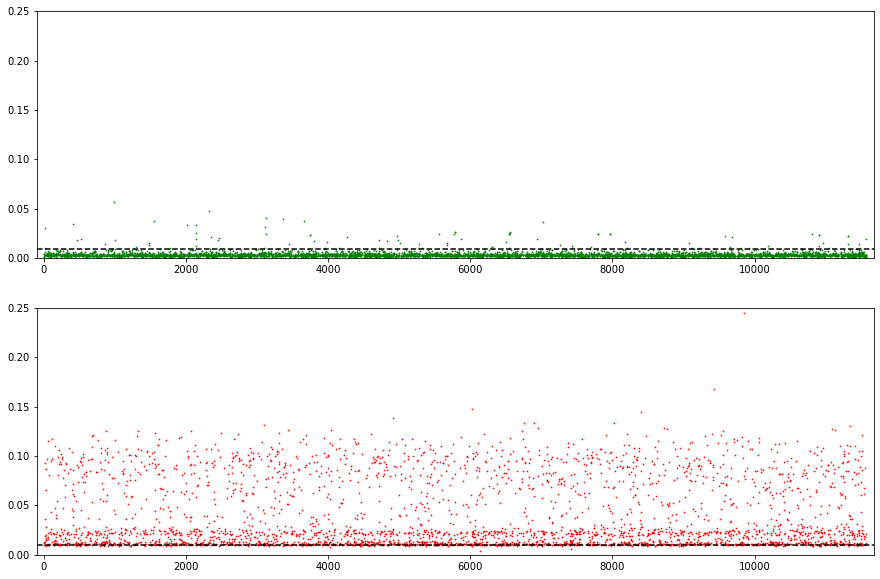

In [38]:
# 做出散点图。其中，虚线表示阈值。
plt.figure(figsize=(15, 10))
plt.subplot(2, 1, 1)
plt.scatter(npNormalX % nTotalLen, npNormalScores, c="green", s=0.5)
plt.hlines(fThreshold, xmin=-100, xmax=nTotalLen + 100, linestyles="dashed")
plt.xlim([-100, nTotalLen + 100])
plt.ylim([0, 0.25])

plt.subplot(2, 1, 2)
plt.scatter(npAbnormalX % nTotalLen, npAbnormalScores, c="red", s=0.5)
plt.hlines(fThreshold, xmin=-100, xmax=nTotalLen + 100, linestyles="dashed")
plt.xlim([-100, nTotalLen + 100])
plt.ylim([0, 0.25])
plt.show()